<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">1. INTRODUCTION</div>

This notebook is to present the task of forecasting the future value of a given stock, given the historical daily close price to forecase its future prices by applying LSTM model.

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em;  font-size: 25px">2. SETUP</div>

In [1]:
import numpy as np
import pandas as pd
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# sklearn libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')
sns.set_context('talk')

C:\Users\Mai\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">3. DATASET</div>

In [2]:
# Install yahoo finance
#!pip install yfinance

import yfinance as yf

In [3]:
STOCK_INDEX = 'GOOG'
VERBOSE = True

# train data from 04/01/2020 until 11/01/2020
start_train_date = '2020-04-01'
end_train_date = '2022-01-11'
train_ds = yf.download(STOCK_INDEX, start=start_train_date, end=end_train_date, progress=True)
X_train_value = train_ds.Close.values.reshape(-1,1)

# test data from 11/01/2022 until 11/03/2022
start_test_date = '2022-01-11'
end_test_date = '2022-03-11'
test_ds = yf.download(STOCK_INDEX, start=start_test_date, end=end_test_date, progress=True)
X_test_value = test_ds.Close.values.reshape(-1,1)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
print(len(X_train_value), len(X_test_value))
train_ds.head()

449 41


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2020-04-01,55.020397,56.218226,54.613826,55.835537,46884000
2020-04-02,55.777809,56.077389,54.561570,54.654130,39298000
2020-04-03,54.635223,55.912172,53.735983,55.686989,46268000
2020-04-06,59.066238,59.451415,56.280433,56.631770,53294000
2020-04-07,59.045834,60.961261,58.832842,60.762203,47746000


In [5]:
train_ds.tail()

Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2022-01-04,143.735703,145.918859,143.138176,144.864359,22928000
2022-01-05,137.004593,143.617771,136.875201,143.501318,49642000
2022-01-06,136.902557,139.027502,136.118779,136.849312,29050000
2022-01-07,136.358643,137.602993,135.148873,137.254895,19408000
2022-01-10,137.920746,137.986429,132.512858,134.462121,34096000


<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">4. DATA VISUALIZATION</div>

<Axes: xlabel='Date'>

<Figure size 432x288 with 0 Axes>

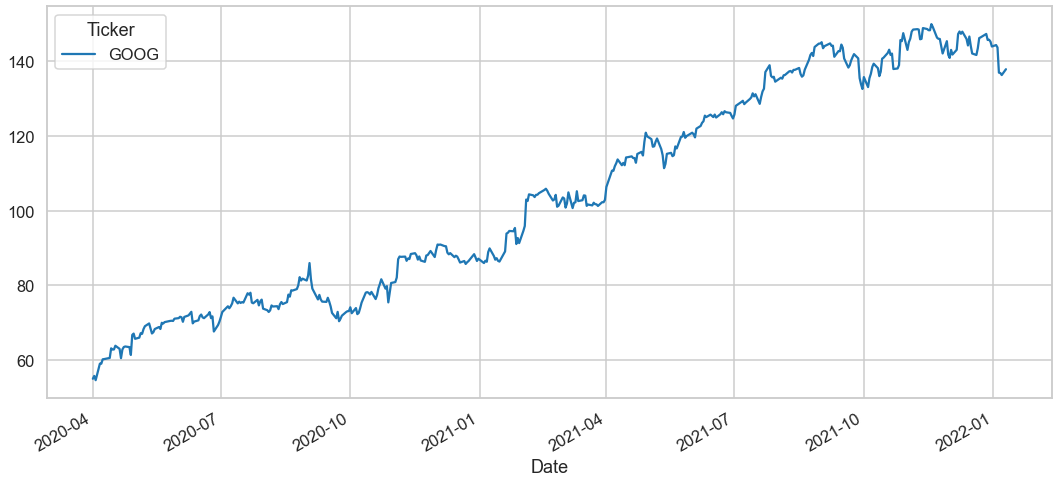

In [6]:
plt.figure()
train_ds.Close.plot(figsize=(18,8))

<Axes: xlabel='Date'>

<Figure size 432x288 with 0 Axes>

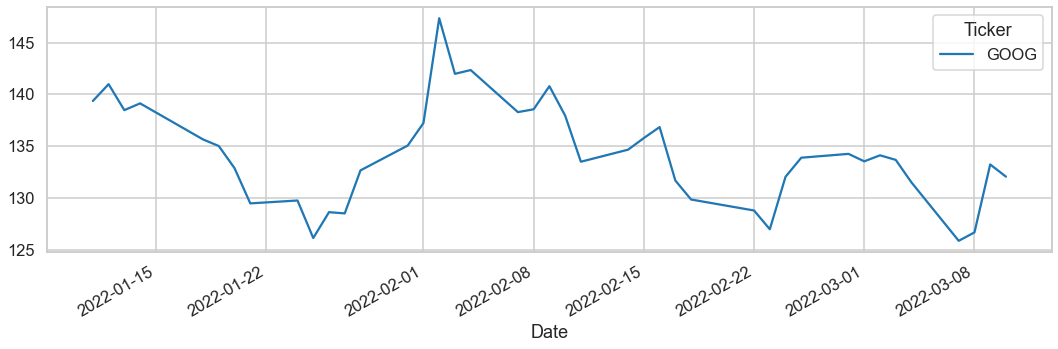

In [7]:
plt.figure()
test_ds.Close.plot(figsize=(18,5))

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">5. DATA PREPROCESSING</div>

 ## <font color=red>**5.1.Set parameters**</font>
 
 Perform certain tweaks to data before building LSTM. In this setting, the input is formatted with the following parameters
 
 + **N (number of sequences)**: This will be set to 1 since we are dealing with only one stock's price information
 + **W (length of sequence)**: This will be set to total number of days worth or price information we have with us. Here we use the whole series as one big sequence
 + **F (features per timestamp)**: This is again 1, as we are only dealing with closing stock value per timestamp

In [8]:
n_input = 60
n_features = 1

## <font color='red'>**5.2. Feature Scaling**

In [9]:
# scale training set
sc = MinMaxScaler(feature_range=(0,1))
scaled_train = sc.fit_transform(X_train_value)

# input for prediction the first value of test set: previous n steps before test set's first value
test_input = pd.concat([train_ds[len(train_ds) - 60:], test_ds], axis=0)
scaled_test = sc.transform(test_input.Close.values.reshape(-1,1))

scaled_train.shape, scaled_test.shape

((449, 1), (101, 1))

## <font color='red'>**5.3. Creating a data structure with 60 timesteps and 1 output**
For using LSTMs to model time series, we need to apply one more level of transformation to be able to traing data. LSTMs accept 3D tensors as input, we transform each of the windows (or sequences) in (N, W, F) format. Here, N is the number of samples or windows from the original time series, W is the size of each window or the number of historical time steps and F is number of features per time step. In this case, as only closing price is used, F is equal to 1

In [10]:
X_train = []
y_train = []

# use last n timesteps as X to predict the next value (y)
for i in range(n_input, len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i, 0])
    y_train.append(scaled_train[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# reshape data for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))
X_train.shape, y_train.shape

((389, 60, 1), (389,))

In [11]:
X_test = []
y_test = []

for i in range(n_input, len(scaled_test)):
    X_test.append(scaled_test[i - n_input:i, 0])
    y_test.append(scaled_test[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)    

# reshape data for LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_features))
X_test.shape, y_test.shape

((41, 60, 1), (41,))

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">6. LSTM - Regression Modeling</div>

In this section we modeled our time series like a regression use case. In essence, the problem formulation though utilized past window to forecast, it did not use the time step information.

Regression Modelling referes to the proceess of investigating relationship between dependent and independent variables as a regresion problem in which the stock price at timestep t+1 (dependent variables) is a function of stockprice at timestep t, t-1, t-2,...,t-n when n is the past window of stock prices

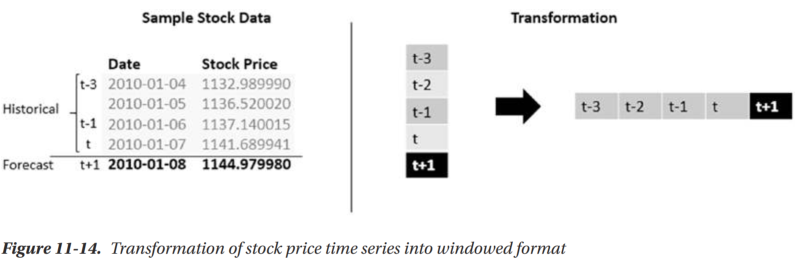

The windowed transformation is outlined in Figure 11-15 where a window size of 4 is used. The value of time t+1 is focasted using past four values. Here, Google stock price is applied this windowed transformation in a rolling fashion and create multiple sequences, each sequence has 60 values (corresponding 60 timesteps for each windowed tranformation)

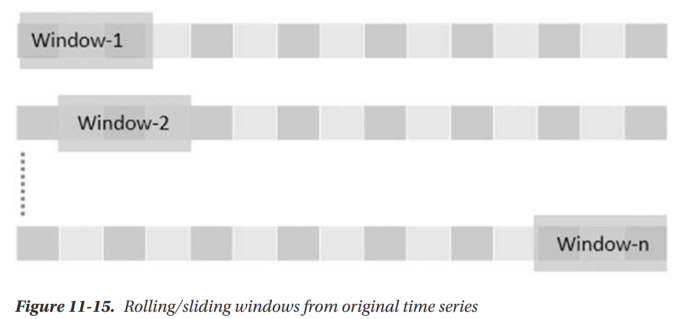

## <font color='red'>**6.1. Importing the Keras libraries and packages** </font>

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

## <font color='red'>**6.2. Constructing LSTM**

In [13]:
# set random seed for reproduciblity
tf.random.set_seed(42)
np.random.seed(42)

# Clear old session
keras.backend.clear_session()
tf.keras.backend.clear_session()

# Define model
model = Sequential()
model.add(LSTM(120, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 120)               58560     
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense (Dense)               (None, 1)                 121       
                                                                 
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________


## <font color='red'>**6.3.  Train model**

The model generates information regarding and validation loss for every epoch it runs. The callback is used for stopping enables stopping the training if there is no furthur improvement observed for four consecutive epochs.

In [14]:
model.fit(X_train, y_train, epochs = 30, batch_size = 30)

Epoch 1/30
13/13 [==============================] - 7s 79ms/step - loss: 0.0929
Epoch 2/30
13/13 [==============================] - 1s 93ms/step - loss: 0.0131: 0s - loss:
Epoch 3/30
13/13 [==============================] - 1s 81ms/step - loss: 0.0056
Epoch 4/30
13/13 [==============================] - 1s 85ms/step - loss: 0.0034
Epoch 5/30
13/13 [==============================] - 1s 77ms/step - loss: 0.0031
Epoch 6/30
13/13 [==============================] - 1s 79ms/step - loss: 0.0029
Epoch 7/30
13/13 [==============================] - 1s 78ms/step - loss: 0.0026
Epoch 8/30
13/13 [==============================] - 1s 72ms/step - loss: 0.0029
Epoch 9/30
13/13 [==============================] - 1s 84ms/step - loss: 0.0024
Epoch 10/30
13/13 [==============================] - 1s 85ms/step - loss: 0.0026
Epoch 11/30
13/13 [==============================] - 1s 78ms/step - loss: 0.0026
Epoch 12/30
13/13 [==============================] - 1s 73ms/step - loss: 0.0028
Epoch 13/30
13/13 [======

## <font color='red'>**6.4. Show training history**

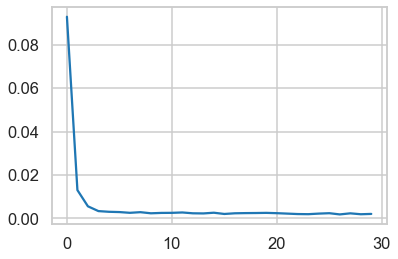

In [15]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

## <font color='red'>**6.5. Prediction**

In [16]:
prediction = model.predict(X_test)
prediction = prediction.reshape(-1,1)
prediction = sc.inverse_transform(prediction)
prediction[0:10]

array([[139.1354 ],
       [138.34479],
       [137.91989],
       [137.54459],
       [137.29935],
       [136.86859],
       [136.32129],
       [135.57362],
       [134.48726],
       [133.31598]], dtype=float32)

In [17]:
test_ds['Prediction'] = prediction
test_ds.head(10)

Price,Close,High,Low,Open,Volume,Prediction
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,
Date,,,,,,
2022-01-11,139.357452,139.667978,136.168561,137.529107,23502000,139.135406
2022-01-12,140.980240,142.141002,140.446771,140.887190,23642000,138.344788
2022-01-13,138.475128,142.510519,138.259156,141.171859,26566000,137.919891
2022-01-14,139.127533,140.534869,136.851813,136.851813,23826000,137.544586
2022-01-18,135.648010,136.743818,134.977693,135.956060,27382000,137.299347
2022-01-19,135.012512,137.747073,134.861236,136.292962,20796000,136.868591
2022-01-20,132.877136,137.261871,132.516843,135.870466,21930000,136.321289
2022-01-21,129.478729,134.125224,129.388170,132.384962,41920000,135.573624


## <font color='red'>**6.6. Visualizing the results**

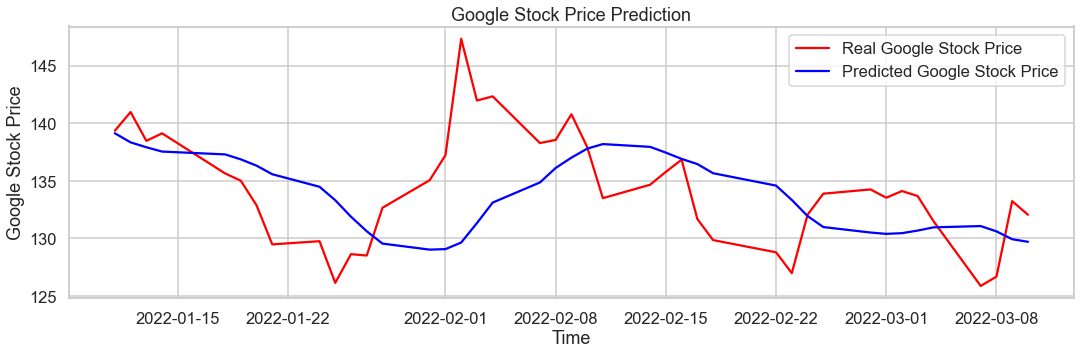

In [18]:
plt.figure(figsize=(18,5))
plt.plot(test_ds.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

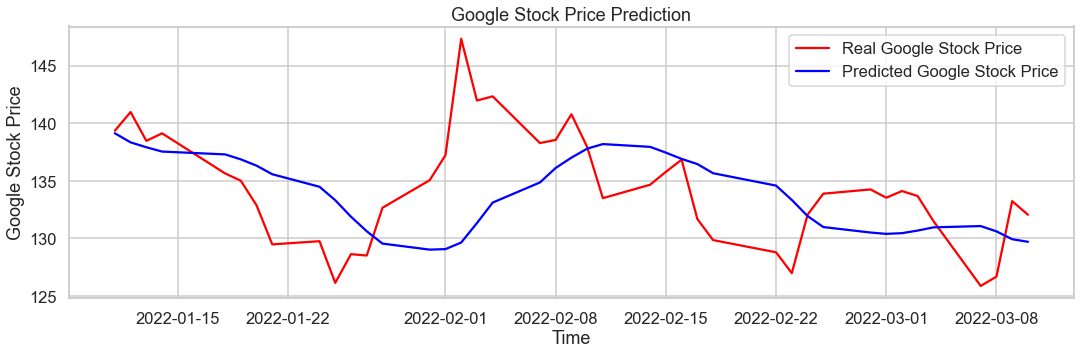

In [19]:
plt.figure(figsize=(18,5))
plt.plot(test_ds.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

## <font color='red'>**6.7. Model Performance**

In [20]:
import math

test_rmse = math.sqrt(mean_squared_error(test_ds['Close'] , test_ds['Prediction'] ))
test_rmse

5.157395896413972

## <font color='red'>**6.8.Forecast 60 time steps ahead**

In [21]:
start_forecast_date = '2022-01-11'
end_forecast_date = '2022-03-11'
forecast_ds = yf.download(STOCK_INDEX, start=start_forecast_date, end=end_forecast_date, progress=True)
X_forecast_value = forecast_ds.Close.values.reshape(-1,1)
scaled_forecast = sc.transform(forecast_ds.Close.values.reshape(-1, 1))

X_forecast = []
y_forecast = []


# use last 60 timesteps (X) to predict the next value (y)
for i in range(n_input, len(scaled_test)):
    X_forecast.append(scaled_test[i-n_input:i, 0])
    y_forecast.append(scaled_test[i, 0])
X_forecast = np.array(X_forecast)

# reshape data for LSTM model
X_forecast = np.reshape(X_forecast, (X_forecast.shape[0], X_forecast.shape[1], n_features))
X_forecast.shape

[*********************100%***********************]  1 of 1 completed


(41, 60, 1)

In [22]:
forecast = []

first_batch = scaled_forecast[0:n_input, 0]
current_batch = X_forecast[0,:,:].reshape((1, n_input, n_features))

for i in range(len(X_forecast)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    #print(current_pred)
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [23]:
#total = np.concatenate([first_eval_batch , np.array(forecast).flatten()])
#total = total.reshape(-1,1)
true_forecast = sc.inverse_transform(forecast)
forecast_ds['Forecast'] = true_forecast

forecast_ds.head()

Price,Close,High,Low,Open,Volume,Forecast
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,
Date,,,,,,
2022-01-11,139.357452,139.667978,136.168561,137.529107,23502000,139.135399
2022-01-12,140.980240,142.141002,140.446771,140.887190,23642000,138.326336
2022-01-13,138.475128,142.510519,138.259156,141.171859,26566000,137.672188
2022-01-14,139.127533,140.534869,136.851813,136.851813,23826000,137.118505
2022-01-18,135.648010,136.743818,134.977693,135.956060,27382000,136.632987


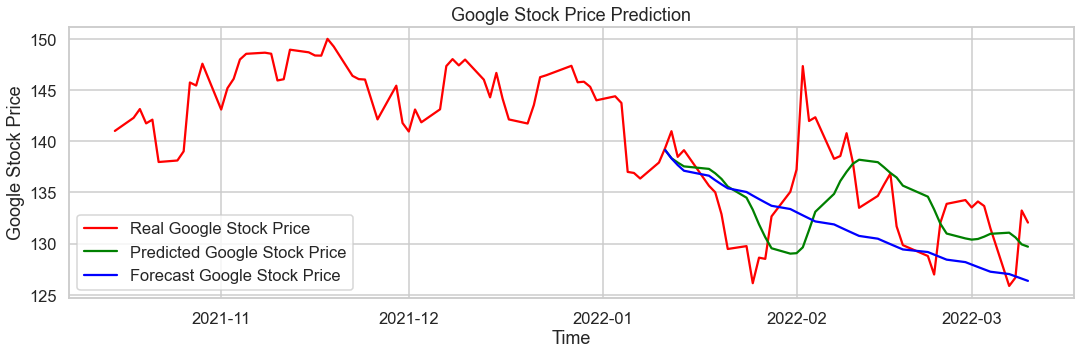

In [24]:
plt.figure(figsize=(18,5))
plt.plot(test_input.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'green', label = 'Predicted Google Stock Price')
plt.plot(forecast_ds.Forecast, color = 'blue', label = 'Forecast Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [25]:
ds = pd.concat([train_ds, test_ds], axis=0)

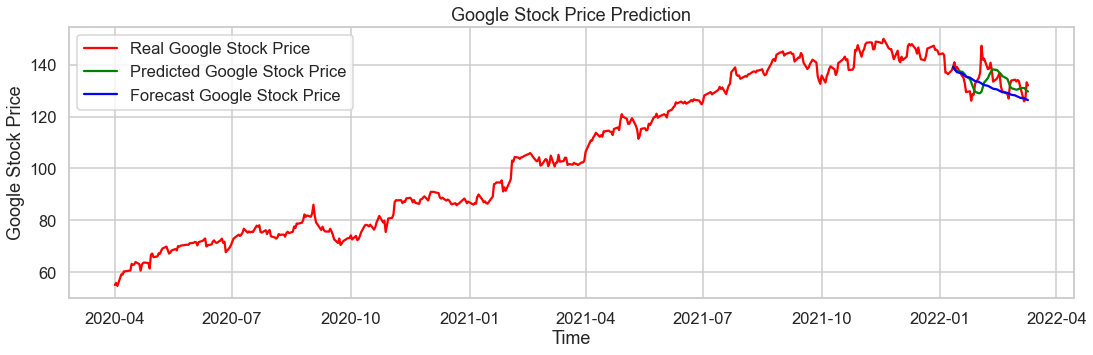

In [26]:
plt.figure(figsize=(18,5))
plt.plot(ds.Close, color = 'red', label = 'Real Google Stock Price')
plt.plot(test_ds.Prediction, color = 'green', label = 'Predicted Google Stock Price')
plt.plot(forecast_ds.Forecast, color = 'blue', label = 'Forecast Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist"></div>

# <div style="text-align: left; background-color:#1192AA; font-family: Trebuchet MS; color: #EEE8A9; padding: 13px; line-height:0.9;border-radius:2px; margin-bottom: 0em; font-size: 25px">7. LSTM - Sequence Modeling</div>

In this section, we will solve the same stock prediction problem using LSTMs by modeling it as a sequence. 

Recurrent neural networks are naturally suited for sequence modelling tasks like machine translation, speech recognition and so on. RNNs utilize memory (unlike normal feed forward neural networks) to keep track of context and utilize the same to generate outputs. In general **feed forward neural network assume inputs are independent of each other. This independence may not hold in many scenarios (such as time series data). RNNs apply same transformations to each element of the sequence, with outcomes being dependent upon previous values**

In case of our stock price time series, we would like to model it now as sequence where value at each time step is a function of previous values. Unlike the regression-like modeling, here we do not divide the time series into windows of fixed sizes, rather we would utilize the LSTMs to learn from the data and determine which past values to utilize for forecasting

In [27]:
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout

from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

## <font color='red'>**Creating timeseries data structure for training LSTM**

In [28]:
train = np.reshape(scaled_train, (1, scaled_train.shape[0],1))
X_train = train[:,:-1,:]
y_train = train[:,1:,:]


test = np.reshape(scaled_test, (1, scaled_test.shape[0],1))
X_test = test[:,:-1,:]
y_test = test[:,1:,:]

print("Data Split Complete")
print("train_x shape={}".format(X_train.shape))
print("train_y shape={}".format(y_train.shape))
print("test_x shape={}".format(X_test.shape))
print("test_y shape={}".format(y_test.shape))

Data Split Complete
train_x shape=(1, 448, 1)
train_y shape=(1, 448, 1)
test_x shape=(1, 100, 1)
test_y shape=(1, 100, 1)


## <font color='red'>**Prepare LSTM Model** </font>

The requirement in this case is to apply similar transformations/processing for every time step and be able to get output for every input timestamp rather than waiting for the whole sequence to be processed. To enable such scenarios, keras provides a wrapper over dense layers called TimeDistributed. This wrapper applies the same task to every time step and provides hooks to get output after each such time step. We use TimeDistributed wrapper over Dense layer to get output from each of the time step being processed.

In [29]:
# set random seed for reproduciblity
tf.random.set_seed(42)
np.random.seed(42)

# Clear old session
keras.backend.clear_session()
tf.keras.backend.clear_session()

In [30]:
# Get stacked LSTM model for sequence modeling
def get_seq_model(hidden_units=4,input_shape=(1,1),verbose=False):
    # create and fit the LSTM network
    model = Sequential()
    # samples*timesteps*featuress

    model.add(LSTM(input_shape=input_shape, units = hidden_units, return_sequences=True ))
    
    # readout layer. TimeDistributedDense uses the same weights for all
    # time steps.
    model.add(TimeDistributed(Dense(1)))
    start = time.time()
    
    model.compile(loss="mse", optimizer="rmsprop")
    
    if verbose:
        print("> Compilation Time : ", time.time() - start)
        print(model.summary())
        
    return model


In [31]:
# build RNN model
seq_lstm_model=None
try:
    seq_lstm_model = get_seq_model(hidden_units=50, input_shape=(X_train.shape[1],1),verbose=VERBOSE)   
except:
    print("Model Build Failed. Trying Again")
    seq_lstm_model = get_seq_model(hidden_units=50, input_shape=(X_train.shape[1],1),verbose=VERBOSE)

> Compilation Time :  0.013757467269897461
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 448, 50)           10400     
                                                                 
 time_distributed (TimeDistr  (None, 448, 1)           51        
 ibuted)                                                         
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
None


This function returns a single hidden layer RNN network with four LSTM units and a TimeDistributed Dense output layer. We again use mean squared error as our loss function

The summary table shows the total parameters which the RNN tries to learn, a complete 101 of them. This model has far few parameters to learn. This summary also points toward an important fact, the shape of the first LSTM layer. This clearly shows that the model expects the inputs to adhere to this shape (the shape of the training dataset) for training as well as predicting.

Since our test dataset is smaller (shape: (1, 842, 1)), we need some way to match the required shape. While modeling sequences with RNNs, it is a common practice to pad sequences in order to match a given shape. Usually in cases where there are multiple sequences to train upon (example, text generation), the size of the longest sequence is used and the shorter ones are padded to match it. We do so only for programmatic reasons and discard the padded values otherwise. The padding utitlity is available from the keras.preprocessing.sequence module. The following snippet pads the test dataset with os post the actual data (you can choose between pre-pad and post pad) and then uses the padded sequence to predict/forecast. We also calculate and print the RMSE score of the forecast

## <font color='red'>**Fit the Model**

In [32]:
# train the model
seq_lstm_model.fit(X_train, y_train, epochs=150, batch_size=1, verbose=2)
print("Model Fit Complete")

Epoch 1/150
1/1 - 5s - loss: 0.4554 - 5s/epoch - 5s/step
Epoch 2/150
1/1 - 0s - loss: 0.2940 - 116ms/epoch - 116ms/step
Epoch 3/150
1/1 - 0s - loss: 0.2057 - 187ms/epoch - 187ms/step
Epoch 4/150
1/1 - 0s - loss: 0.1364 - 178ms/epoch - 178ms/step
Epoch 5/150
1/1 - 0s - loss: 0.0783 - 119ms/epoch - 119ms/step
Epoch 6/150
1/1 - 0s - loss: 0.0327 - 226ms/epoch - 226ms/step
Epoch 7/150
1/1 - 0s - loss: 0.0074 - 188ms/epoch - 188ms/step
Epoch 8/150
1/1 - 0s - loss: 0.0038 - 117ms/epoch - 117ms/step
Epoch 9/150
1/1 - 0s - loss: 0.0035 - 168ms/epoch - 168ms/step
Epoch 10/150
1/1 - 0s - loss: 0.0032 - 123ms/epoch - 123ms/step
Epoch 11/150
1/1 - 0s - loss: 0.0030 - 110ms/epoch - 110ms/step
Epoch 12/150
1/1 - 0s - loss: 0.0028 - 108ms/epoch - 108ms/step
Epoch 13/150
1/1 - 0s - loss: 0.0027 - 201ms/epoch - 201ms/step
Epoch 14/150
1/1 - 0s - loss: 0.0025 - 147ms/epoch - 147ms/step
Epoch 15/150
1/1 - 0s - loss: 0.0025 - 109ms/epoch - 109ms/step
Epoch 16/150
1/1 - 0s - loss: 0.0026 - 169ms/epoch - 16

Epoch 129/150
1/1 - 0s - loss: 0.0023 - 168ms/epoch - 168ms/step
Epoch 130/150
1/1 - 0s - loss: 0.0020 - 207ms/epoch - 207ms/step
Epoch 131/150
1/1 - 0s - loss: 0.0022 - 242ms/epoch - 242ms/step
Epoch 132/150
1/1 - 0s - loss: 0.0019 - 178ms/epoch - 178ms/step
Epoch 133/150
1/1 - 0s - loss: 0.0022 - 167ms/epoch - 167ms/step
Epoch 134/150
1/1 - 0s - loss: 0.0019 - 193ms/epoch - 193ms/step
Epoch 135/150
1/1 - 0s - loss: 0.0022 - 142ms/epoch - 142ms/step
Epoch 136/150
1/1 - 0s - loss: 0.0019 - 181ms/epoch - 181ms/step
Epoch 137/150
1/1 - 0s - loss: 0.0022 - 188ms/epoch - 188ms/step
Epoch 138/150
1/1 - 0s - loss: 0.0019 - 176ms/epoch - 176ms/step
Epoch 139/150
1/1 - 0s - loss: 0.0021 - 223ms/epoch - 223ms/step
Epoch 140/150
1/1 - 0s - loss: 0.0018 - 123ms/epoch - 123ms/step
Epoch 141/150
1/1 - 0s - loss: 0.0021 - 117ms/epoch - 117ms/step
Epoch 142/150
1/1 - 0s - loss: 0.0018 - 236ms/epoch - 236ms/step
Epoch 143/150
1/1 - 0s - loss: 0.0020 - 236ms/epoch - 236ms/step
Epoch 144/150
1/1 - 0s - 

## <font color='red'>**Train Prediction Performance**

In [33]:
# train fit performance
trainPredict = seq_lstm_model.predict(X_train)
trainScore = math.sqrt(mean_squared_error(y_train[0], trainPredict[0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.04 RMSE


## <font color='red'>**Test Prediction Performance**

In [34]:
# Pad input sequence
testPredict = pad_sequences(X_test, maxlen=X_train.shape[1], padding='post', dtype='float64')

# forecast values
testPredict = seq_lstm_model.predict(testPredict)

In [35]:
# evaluate performances
testScore = math.sqrt(mean_squared_error(y_test[0][:X_test.shape[1]], testPredict[0][:X_test.shape[1]]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 0.17 RMSE


## <font color='red'>**Plot Test Predictions**

We next use the scaler object to perform an inverse transformation to get the prediction values in the original scale.

In [36]:
# inverse transformation
trainPredict = sc.inverse_transform(trainPredict.reshape(-1,1))
testPredict = sc.inverse_transform(testPredict.reshape(-1,1))

#trainPredict = trainPredict.reshape(-1,1)
#testPredict = testPredict.reshape(-1,1)

In [37]:
ds = pd.concat([train_ds, test_ds], axis=0)

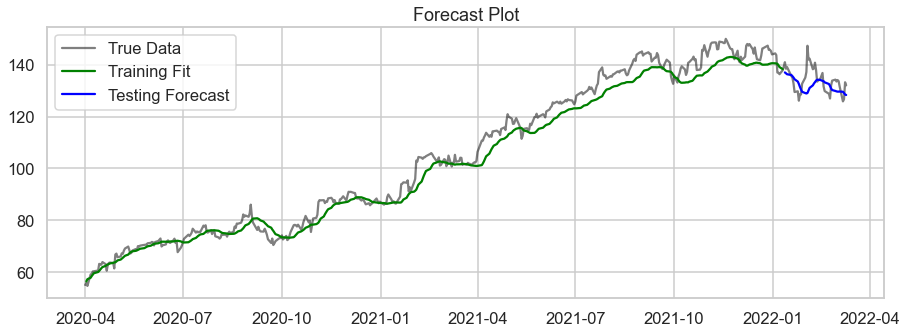

In [38]:
# plot the true and forecasted values
train_size = len(trainPredict)+1
test_size = len(X_test)
plt.figure(figsize=(15,5))
plt.plot(ds.index,
         ds.Close,c='black',
         alpha=0.5,label='True Data')
plt.plot(ds.index[1:train_size],trainPredict,label='Training Fit',c='g')
#plt.plot(sp_close_series.index[train_size+20:],testPredict[19:test_x.shape[1]],label='Testing Forecast', c='b')
plt.plot(ds.index[train_size+1:],testPredict[n_input:X_test.shape[1]],label='Testing Forecast', c='b')
plt.title('Forecast Plot')
plt.legend()
plt.show()